# Validate the trained model and choose a threshold

This jupyter notebook helps user to visualize and validate results form their trained model. Also, it helps usdsr to pick a threshold based on the: 1) density score of the validation dataset (which does not include any images with anomalies), and 2) some known examples of images with anomalies.

In [1]:
# Import libraries
import json
import os
import random

import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.neighbors import KernelDensity
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from das_anomaly import calculate_percentile, density
from das_anomaly.settings import SETTINGS

## Import parameters and define the generators

In [2]:
# Import the specified path to the saved trained model from pre-defined config_user.py
results_path = SETTINGS.TRAINED_PATH

# Import the size of the input images
size = SETTINGS.SIZE

# Import the define generators for training, validation and also anomaly data.
batch_size = SETTINGS.BATCH_SIZE
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Path to training PSD plots (seen data)
train_path = SETTINGS.TRAIN_IMAGES_PATH
train_generator = datagen.flow_from_directory(
    train_path, target_size=(size, size), batch_size=batch_size, class_mode="input"
)

# Path to testing PSD plots (unseen data)
test_path = SETTINGS.TEST_IMAGES_PATH
validation_generator = datagen.flow_from_directory(
    test_path, target_size=(size, size), batch_size=batch_size, class_mode="input"
)

# Path to known anomalies
events_path = SETTINGS.ANOMALY_IMAGES_PATH
anomaly_generator = datagen.flow_from_directory(
    events_path, target_size=(size, size), batch_size=batch_size, class_mode="input"
)

Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


In [15]:
results_path

'./data/'

In [3]:
# Load the saved trained model and its history
model_path = os.path.join(results_path, f"model_{size}.h5")
loaded_model = tf.keras.models.load_model(model_path)

# Compile the model with the same trained parameters
loaded_model.compile(
    optimizer="adam", loss="mse", metrics=[keras.metrics.MeanSquaredError()]
)

with open(os.path.join(results_path, f"history_{size}.json")) as json_file:
    history_dict = json.load(json_file)

## Sanity check anomolous and normal, event-free data

### Event-free data

In [4]:
# Get all batches generated by the datagen and pick a batch for prediction
data_batch_validation = []
batch_num = 0
while (
    batch_num <= validation_generator.batch_index
):  # Gets each generated batch of size batch_size
    data = next(validation_generator)
    data_batch_validation.append(data[0])
    batch_num = +1

predicted = loaded_model.predict(
    data_batch_validation[0]
)  # Predict on the first batch of images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


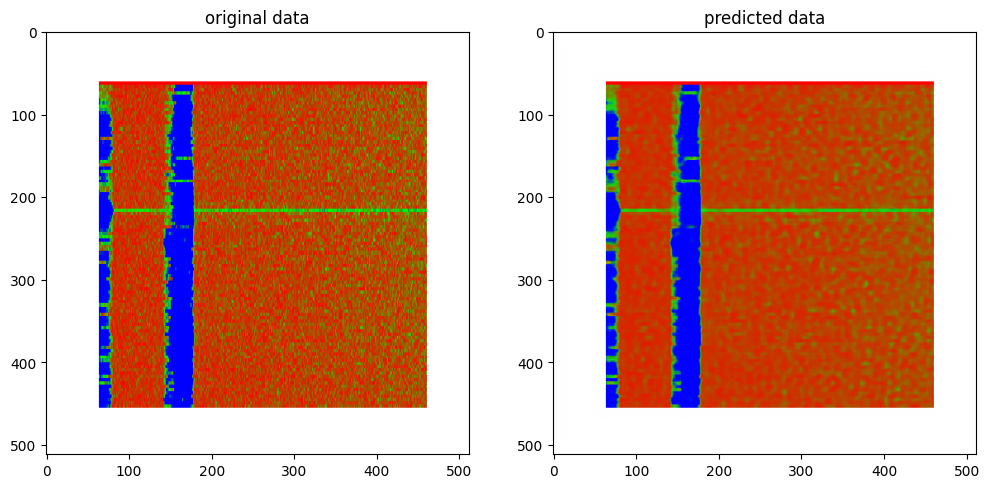

In [5]:
# Sanity check normal (event-free) data and view an image and corresponding reconstruction
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch_validation[0][image_number])
plt.title("original data")
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.title("predicted data")
plt.show()

### Anomalous data

In [6]:
# Get all batches generated by the datagen and pick a batch for prediction
data_batch_anomaly = []
img_num = 0
while (
    img_num <= anomaly_generator.batch_index
):  # Gets each generated batch of size batch_size
    data = next(anomaly_generator)
    data_batch_anomaly.append(data[0])
    img_num = img_num + 1

predicted = loaded_model.predict(
    data_batch_anomaly[0]
)  # Predict on the first batch of images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


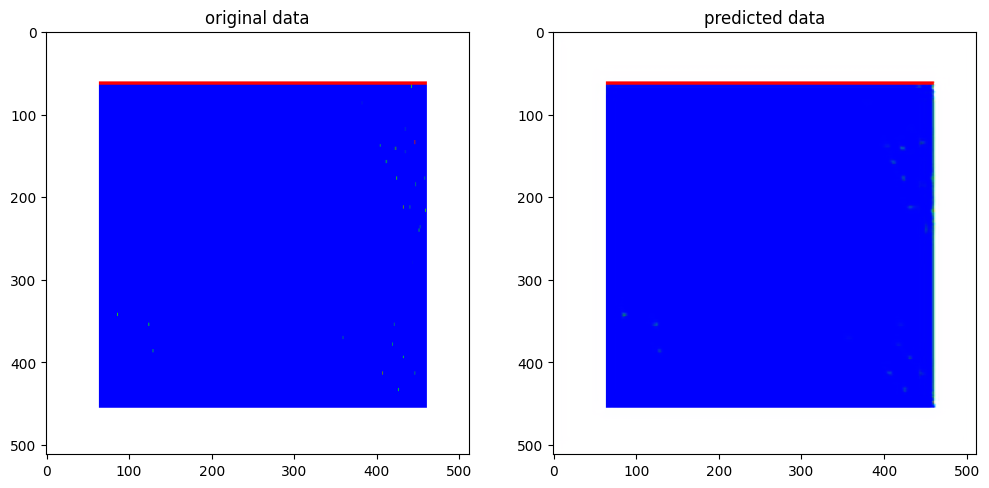

In [8]:
# Sanity check anomalous data: plot an image and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch_anomaly[0][image_number])
plt.title("original data")
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.title("predicted data")
plt.show()

## Compare the MSE reconstruction error between event-free and anomalous datasets

In [9]:
# Examine the reconstruction error between our validation data (which are normal, event-free images) and the anomalous images
validation_error = loaded_model.evaluate(validation_generator)

# Evaluate the model using the anomaly data generator
anomaly_error = loaded_model.evaluate(anomaly_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step - loss: 0.0074 - mean_squared_error: 0.0074
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step - loss: 0.0123 - mean_squared_error: 0.0123


In [10]:
# Build the encoder network, with trained weights.
# This is used to get the compressed output (latent space) of the input image.
# The compressed output is then used to calculate the KDE and density scores
encoder_model = Sequential()
# Add the convolutional layer without weights
encoder_model.add(
    Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(size, size, 3))
)
# Set the weights from the corresponding layer of the loaded model
encoder_model.layers[-1].set_weights(loaded_model.layers[0].get_weights())
encoder_model.add(MaxPooling2D((2, 2), padding="same"))
encoder_model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
encoder_model.layers[-1].set_weights(loaded_model.layers[2].get_weights())
encoder_model.add(MaxPooling2D((2, 2), padding="same"))
encoder_model.add(Conv2D(16, (3, 3), activation="relu", padding="same"))
encoder_model.layers[-1].set_weights(loaded_model.layers[4].get_weights())

encoder_model.add(MaxPooling2D((2, 2), padding="same"))
encoder_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 512, 512, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,880 (97.19 KB)

 Trainable params: 24,880 (97.19 KB)

 Non-trainable params: 0 (0.00 B)

## Calculate kernel density estimation (KDE) 

In [11]:
# Compute latent space representations
encoded_images = encoder_model.predict(train_generator)

# Flatten latent space representations because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape
out_vector_shape = (
    encoder_output_shape[1] * encoder_output_shape[2] * encoder_output_shape[3]
)

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

# Fit a kernel density model to the latent representations
kde = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(encoded_images_vector)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


In [12]:
# Process all_train_batches and all_anomaly_batches as needed
normal_values = density(encoder_model, np.vstack(data_batch_validation), kde)
anomolous_values = density(encoder_model, np.vstack(data_batch_anomaly), kde)

## Plot the histogram and choose a thereshold

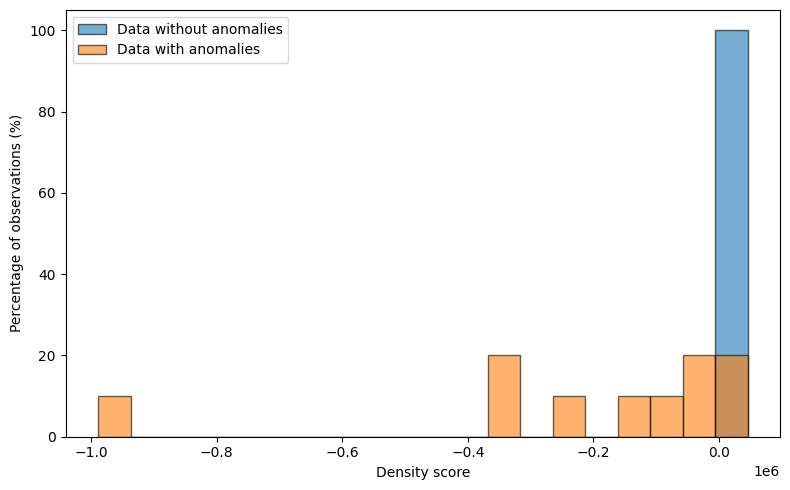

In [13]:
# build common bin edges
n_bins = 20 
bin_edges = np.linspace(
    min(normal_values.min(), anomolous_values.min()),
    max(normal_values.max(), anomolous_values.max()),
    n_bins + 1  # +1 because edges = bins + 1
)

# convert counts to percentages 
w_normal = np.ones_like(normal_values)  / normal_values.size   * 100   # sums to 100 %
w_anom   = np.ones_like(anomolous_values) / anomolous_values.size * 100

# figure 
plt.figure(figsize=(8, 5))

plt.hist(
    normal_values,
    bins=bin_edges,
    weights=w_normal,
    alpha=0.6,
    label="Data without anomalies",
    edgecolor="k",
)

plt.hist(
    anomolous_values,
    bins=bin_edges,
    weights=w_anom,
    alpha=0.6,
    label="Data with anomalies",
    edgecolor="k",
)

plt.xlabel("Density score")
plt.ylabel("Percentage of observations (%)")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Choose a thereshold based on desired percentile and then update the config_user module and use it for anomaly detection (in the detect_anomalies scripts)
percentile = 95
percentile_value = calculate_percentile(anomolous_values, percentile)
print(percentile_value)

17998.56993888313
